In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import timm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Dataset path
data_dir = "/kaggle/input/utkface-new/UTKFace"

In [4]:
# Load data with filtering
image_paths, labels = [], []
for fname in os.listdir(data_dir):
    if fname.endswith(".jpg"):
        try:
            age = int(fname.split("_")[0])
            if 0 < age < 120:
                image_paths.append(os.path.join(data_dir, fname))
                labels.append(age)
        except:
            continue

data_df = pd.DataFrame({"path": image_paths, "age": labels})

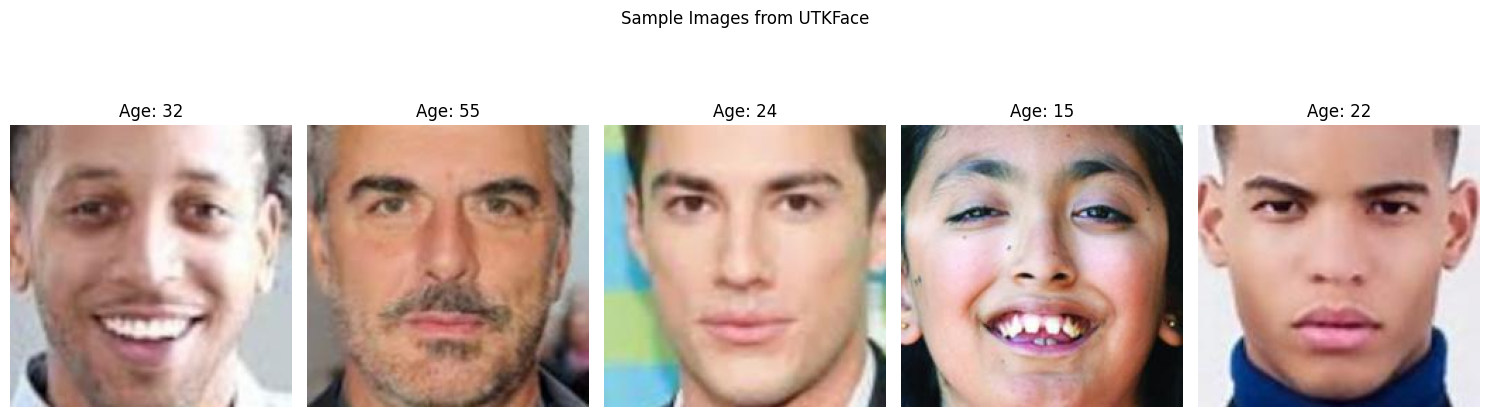

In [5]:
# Print 5 random samples
sample_df = data_df.sample(5).reset_index(drop=True)
plt.figure(figsize=(15, 5))
for i in range(5):
    img = cv2.imread(sample_df.loc[i, 'path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Age: {sample_df.loc[i, 'age']}")
    plt.axis('off')
plt.suptitle("Sample Images from UTKFace")
plt.tight_layout()
plt.show()

In [6]:
# Splits
train_df, test_df = train_test_split(data_df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)
print("Train Shape: ", train_df.shape)
print("Val Shape: ", val_df.shape)
print("Test Shape: ", test_df.shape)

Train Shape:  (17128, 2)
Val Shape:  (3023, 2)
Test Shape:  (3557, 2)


In [7]:
# Albumentations augmentations
transform_train = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.CoarseDropout(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [8]:
# Dataset class
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, 'path']
        age = self.df.loc[idx, 'age']
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, torch.tensor(age, dtype=torch.float32)

In [9]:
# Loaders
train_loader = DataLoader(UTKFaceDataset(train_df, transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(UTKFaceDataset(val_df, transform_val), batch_size=32, shuffle=False)
test_loader = DataLoader(UTKFaceDataset(test_df, transform_val), batch_size=32, shuffle=False)

In [10]:
# Model using timm backbone
model = timm.create_model('convnext_base', pretrained=True)

in_features = model.head.in_features if hasattr(model.head, 'in_features') else model.head.fc.in_features
model.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, 1)
)
model.to(device)

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [11]:
# Loss and Optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)
scaler = GradScaler()

/tmp/ipykernel_35/3429787272.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [12]:
# Training loop
best_val_loss = float('inf')
train_losses, val_losses = [], []
early_stop_counter = 0

for epoch in range(50):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/50 - Train"):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/50 - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 7:
            print("Early stopping triggered.")
            break

Epoch 1/50 - Train:   0%|          | 0/536 [00:00<?, ?it/s]/tmp/ipykernel_35/1740948966.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 - Train: 100%|██████████| 536/536 [06:04<00:00,  1.47it/s]


Epoch 1/50 - Train Loss: 6.8310, Val Loss: 5.2859


Epoch 2/50 - Train: 100%|██████████| 536/536 [04:20<00:00,  2.05it/s]


Epoch 2/50 - Train Loss: 5.1123, Val Loss: 4.7847


Epoch 3/50 - Train: 100%|██████████| 536/536 [04:20<00:00,  2.06it/s]


Epoch 3/50 - Train Loss: 4.6595, Val Loss: 4.8816


Epoch 4/50 - Train: 100%|██████████| 536/536 [04:21<00:00,  2.05it/s]


Epoch 4/50 - Train Loss: 4.3248, Val Loss: 5.1437


Epoch 5/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.08it/s]


Epoch 5/50 - Train Loss: 4.0660, Val Loss: 5.0616


Epoch 6/50 - Train: 100%|██████████| 536/536 [04:14<00:00,  2.11it/s]


Epoch 6/50 - Train Loss: 3.8305, Val Loss: 5.6116


Epoch 7/50 - Train: 100%|██████████| 536/536 [04:13<00:00,  2.11it/s]


Epoch 7/50 - Train Loss: 3.1617, Val Loss: 4.5138


Epoch 8/50 - Train: 100%|██████████| 536/536 [04:11<00:00,  2.13it/s]


Epoch 8/50 - Train Loss: 2.8998, Val Loss: 4.4205


Epoch 9/50 - Train: 100%|██████████| 536/536 [04:13<00:00,  2.12it/s]


Epoch 9/50 - Train Loss: 2.7285, Val Loss: 4.5095


Epoch 10/50 - Train: 100%|██████████| 536/536 [04:13<00:00,  2.11it/s]


Epoch 10/50 - Train Loss: 2.5990, Val Loss: 4.5612


Epoch 11/50 - Train: 100%|██████████| 536/536 [04:16<00:00,  2.09it/s]


Epoch 11/50 - Train Loss: 2.4315, Val Loss: 4.4133


Epoch 12/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.08it/s]


Epoch 12/50 - Train Loss: 2.3141, Val Loss: 4.4165


Epoch 13/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.09it/s]


Epoch 13/50 - Train Loss: 2.2104, Val Loss: 4.4480


Epoch 14/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.08it/s]


Epoch 14/50 - Train Loss: 2.1019, Val Loss: 4.5507


Epoch 15/50 - Train: 100%|██████████| 536/536 [04:21<00:00,  2.05it/s]


Epoch 15/50 - Train Loss: 2.0157, Val Loss: 4.4598


Epoch 16/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.09it/s]


Epoch 16/50 - Train Loss: 1.8073, Val Loss: 4.3900


Epoch 17/50 - Train: 100%|██████████| 536/536 [04:15<00:00,  2.10it/s]


Epoch 17/50 - Train Loss: 1.7087, Val Loss: 4.4199


Epoch 18/50 - Train: 100%|██████████| 536/536 [04:16<00:00,  2.09it/s]


Epoch 18/50 - Train Loss: 1.6459, Val Loss: 4.4043


Epoch 19/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.08it/s]


Epoch 19/50 - Train Loss: 1.6005, Val Loss: 4.3643


Epoch 20/50 - Train: 100%|██████████| 536/536 [04:16<00:00,  2.09it/s]


Epoch 20/50 - Train Loss: 1.5693, Val Loss: 4.4446


Epoch 21/50 - Train: 100%|██████████| 536/536 [04:18<00:00,  2.08it/s]


Epoch 21/50 - Train Loss: 1.5263, Val Loss: 4.3875


Epoch 22/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.08it/s]


Epoch 22/50 - Train Loss: 1.4946, Val Loss: 4.4612


Epoch 23/50 - Train: 100%|██████████| 536/536 [04:13<00:00,  2.11it/s]


Epoch 23/50 - Train Loss: 1.4434, Val Loss: 4.3765


Epoch 24/50 - Train: 100%|██████████| 536/536 [04:11<00:00,  2.13it/s]


Epoch 24/50 - Train Loss: 1.3956, Val Loss: 4.4056


Epoch 25/50 - Train: 100%|██████████| 536/536 [04:10<00:00,  2.14it/s]


Epoch 25/50 - Train Loss: 1.3646, Val Loss: 4.4264


Epoch 26/50 - Train: 100%|██████████| 536/536 [04:17<00:00,  2.08it/s]


Epoch 26/50 - Train Loss: 1.3499, Val Loss: 4.4115
Early stopping triggered.


In [13]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [14]:
# Test evaluation
true_ages = []
pred_ages = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().squeeze().numpy()
        pred_ages.extend(outputs.tolist())
        true_ages.extend(labels.numpy().tolist())

mae = mean_absolute_error(true_ages, pred_ages)
print(f"\nTest MAE: {mae:.2f} years")


Test MAE: 4.36 years


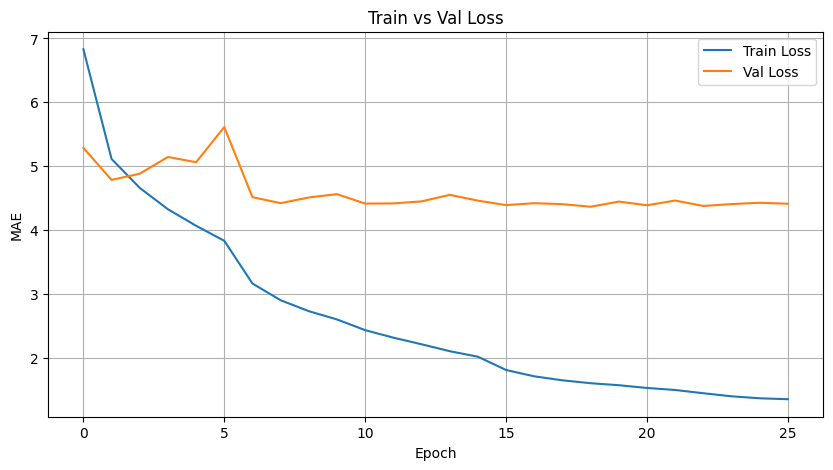

In [15]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid()
plt.show()

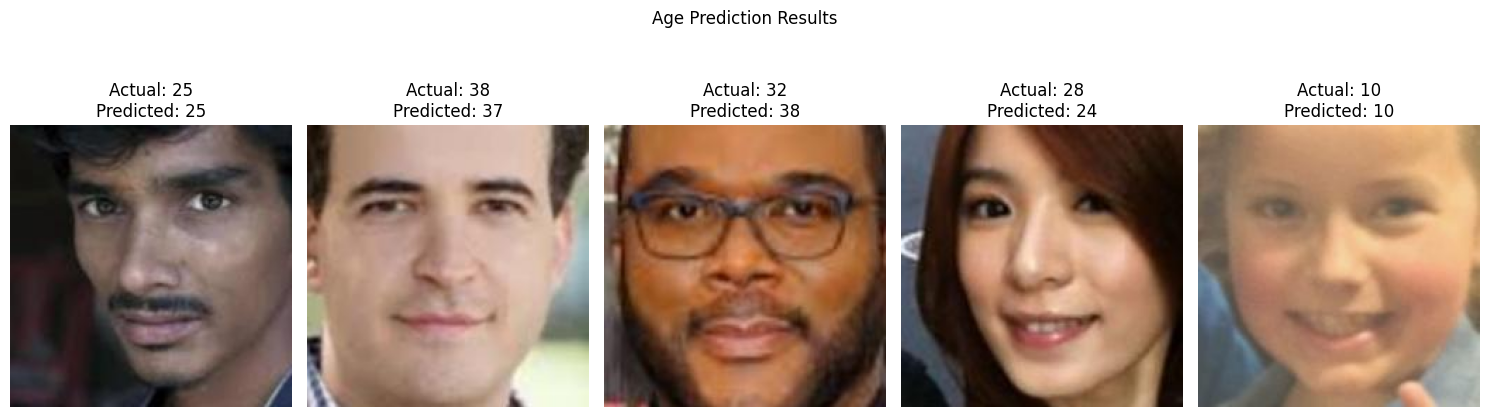

In [24]:
# Sample 5 random indices from the test set
indices = random.sample(range(len(test_df)), 5)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    path = test_df.iloc[idx]['path']
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    actual = test_df.iloc[idx]['age']

    transformed = transform_val(image=img)['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        flipped = torch.flip(transformed, dims=[3])
        pred1 = model(transformed)
        pred2 = model(flipped)
        predicted = ((pred1 + pred2) / 2).cpu().item()

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = f"Actual: {int(actual)}\nPredicted: {int(predicted)}"
    plt.title(title)

plt.suptitle("Age Prediction Results")
plt.tight_layout()
plt.show()


In [33]:
def predict_age_from_path(image_path, model, transform, mtcnn=None):
    model.eval()
    img = Image.open(image_path).convert('RGB')

    if mtcnn is not None:
        aligned = mtcnn(img)
        if aligned is None:
            img = np.array(img)
            img = transform(image=img)['image'].unsqueeze(0).to(device)
        else:
            img = aligned.unsqueeze(0).to(device)
    else:
        img = np.array(img)
        img = transform(image=img)['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        flipped = torch.flip(img, dims=[3])
        pred1 = model(img)
        pred2 = model(flipped)
        predicted_age = ((pred1 + pred2) / 2).cpu().item()

    return predicted_age

custom_path = "/kaggle/input/utkface-new/crop_part1/10_0_0_20170110220503946.jpg.chip.jpg"

predicted = predict_age_from_path(custom_path, model, transform_val, mtcnn=None)
print(f"Predicted Age: {predicted:.2f} years")

Predicted Age: 11.50 years


In [34]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

# Define function to map age to class
def age_to_class(age):
    if age < 10:
        return 0  # Child
    elif age < 20:
        return 1  # Teen
    elif age < 30:
        return 2  # Young Adult
    elif age < 40:
        return 3  # Adult
    elif age < 60:
        return 4  # Middle-aged
    else:
        return 5  # Senior

true_classes = [age_to_class(age) for age in true_ages]
pred_classes = [age_to_class(age) for age in pred_ages]

cm = confusion_matrix(true_classes, pred_classes)
print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=[
    "Child", "Teen", "Young", "Adult", "Middle", "Senior"
]))

Classification Report:
              precision    recall  f1-score   support

       Child       0.95      0.91      0.93       465
        Teen       0.73      0.59      0.65       223
       Young       0.73      0.76      0.75      1087
       Adult       0.49      0.54      0.51       698
      Middle       0.66      0.69      0.68       685
      Senior       0.84      0.68      0.75       399

    accuracy                           0.70      3557
   macro avg       0.73      0.69      0.71      3557
weighted avg       0.71      0.70      0.71      3557



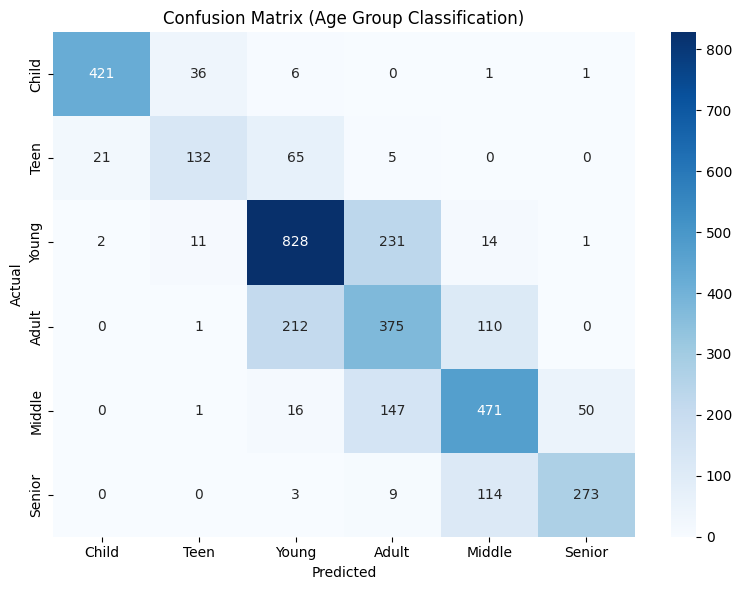

In [35]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Child", "Teen", "Young", "Adult", "Middle", "Senior"],
            yticklabels=["Child", "Teen", "Young", "Adult", "Middle", "Senior"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Age Group Classification)")
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 70.28%
